In [1]:
# importamos las librerías necesarias para trabajar.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importamos librerias de scikit learn para clasificacion y modelos de SVM.
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [3]:
# importamos librearias de Logistic Regression
from sklearn.linear_model import LogisticRegression

In [4]:
#Importamos librerias de Feature Selection
from sklearn.feature_selection import RFECV
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.linear_model import lasso_path
from sklearn.feature_selection import VarianceThreshold

In [5]:
# Importamos librerias de PCA
from sklearn.decomposition import PCA

In [6]:
pwd

'/Users/TobiasHara/Desktop/UTN/6to Año/Ciencia de datos/Clase 6'

# Importamos dataset de Wisconsin Breast Cancer

In [7]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
x = data.data
y = data.target

# Separamos nuestros datos en Train y Test

In [8]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=4)

# Realizamos Auto Scaling

In [9]:
# Step 4: auto scaling train- set (mean = 0, std = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(xtrain)
scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
xtrain_scal = scaler.transform(xtrain)  
xtest_scal = scaler.transform(xtest)  

In [11]:
xtrain_scal.shape

(398, 30)

# Analisis de Componentes Principales (PCA)
Vamos a obtener primeros 10 autovalores y autovectores (eigenvalues y eigenvectors) de la matriz de train "xtrain_scal". 

In [12]:
from sklearn.decomposition import PCA
# cantidad de componentes a extraer
n_comps = 10
# definimos PCA
pca = PCA(n_components= n_comps)
# fit_transform del PCA a nuestros datos
xpca = pd.DataFrame(pca.fit_transform(xtrain_scal))
# obtenemos los auto-valores
eigenvalues = pca.explained_variance_ratio_

In [13]:
eigenvalues

array([0.44604183, 0.18260156, 0.10040269, 0.06410772, 0.05566709,
       0.04241754, 0.02164451, 0.0159364 , 0.01278413, 0.01074278])

In [14]:
# observamos el shape de la matriz obtenida del PCA. Ver que nuestro dataset se redujo de 30 a 10 dimensiones
xpca.shape

(398, 10)

# Observamos los autovalores obtenidos del PCA
Recordemos que los autovalores significa la variabilidad que "atrapa" cada componente principal. Obviamente siempre vamos a priorizar las componentes principales que mayor variabilidad capten de los datos de entrenamiento.

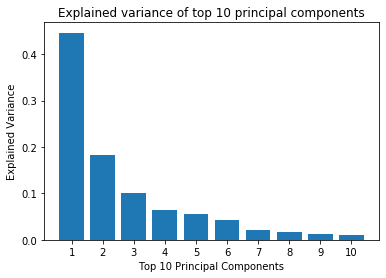

In [15]:
components = range(1,n_comps + 1)
plt.bar(components,eigenvalues)
plt.xticks(components)
plt.title('Explained variance of top 10 principal components')
plt.xlabel('Top 10 Principal Components')
plt.ylabel('Explained Variance')
plt.show()

In [16]:
percentage_var_explained = eigenvalues / np.sum(eigenvalues)
cum_var_explained = np.cumsum(eigenvalues)

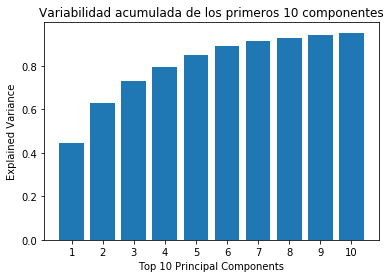

In [17]:
components = range(1,n_comps + 1)
plt.bar(components,cum_var_explained)
plt.xticks(components)
plt.title('Variabilidad acumulada de los primeros 10 componentes')
plt.xlabel('Top 10 Principal Components')
plt.ylabel('Explained Variance')
plt.show()

# Scatter plot del PCA
Con las 2 primeras componentes principales **antes** de la selección de variables visualizamos nuestras muestras/samples de train. **Atencion!** vean que estamos visualizando datos de 30 dimensiones en solamente 2 :). Otro punto importante es que con las dos primeras componentes principales captamos el 65 % aprox de la variabilidad de mis datos (hacer explained variance de PC1 + PC2)

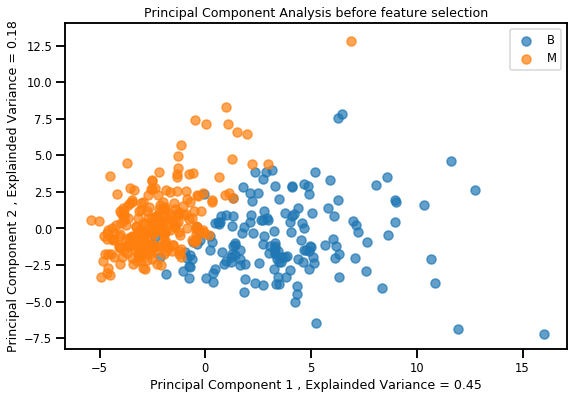

In [18]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(9,6))
plt.scatter(xpca.loc[(ytrain == 0).ravel(),0],xpca.loc[(ytrain == 0).ravel(),1], alpha = 0.7, label = 'B')
plt.scatter(xpca.loc[(ytrain == 1).ravel(),0],xpca.loc[(ytrain == 1).ravel(),1], alpha = 0.7, label = 'M')
plt.xlabel('Principal Component 1 , Explainded Variance = ' + str(np.round(eigenvalues[0],2)))
plt.ylabel('Principal Component 2 , Explainded Variance = ' + str(np.round(eigenvalues[1],2)))
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

Estamos visualizando datos de alta dimension en 2 dimensiones :):):):). Ojo que con las dos primeras componentes visualizamos el 63% de la variabilidad del dataset original. Es decir que sirve para darnos una idea aunque lo que se aconseja es quedarse con las componentes que acumulan aunque sea el 80% de la variabilidad original.

In [19]:
# vamos a visualizar en 3d
from mpl_toolkits.mplot3d import Axes3D

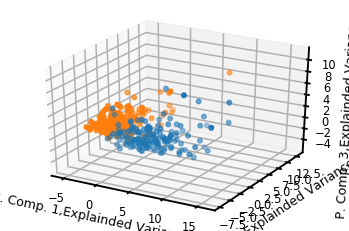

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xpca.iloc[(ytrain == 0).ravel(),0], xpca.iloc[(ytrain == 0).ravel(),1], xpca.iloc[(ytrain == 0).ravel(),2])
ax.scatter(xpca.iloc[(ytrain == 1).ravel(),0], xpca.iloc[(ytrain == 1).ravel(),1], xpca.iloc[(ytrain == 1).ravel(),2])
ax.set_xlabel('P. Comp. 1,Explainded Variance = ' + str(np.round(eigenvalues[0],2)))
ax.set_ylabel('P. Comp. 2,Explainded Variance = ' + str(np.round(eigenvalues[1],2)))
ax.set_zlabel('P. Comp. 3,Explainded Variance = ' + str(np.round(eigenvalues[2],2)))
plt.show()

# kernel-PCA

Computamos el desvio standard de cada feature. Luego decidimos quedarnos con aquellas cuyo STDEV sea mayor a un cuantil determinado. Eso resultara de un vector "mascara" booleano que nos serirá para filtrar el dataset original. Vean que este metodo es no supervisado aunque su debilidad es que es univariado.

In [21]:
from sklearn.decomposition import PCA, KernelPCA

In [22]:
# cantidad de componentes a extraer
n_comps = 10
# definimos PCA
kpca = KernelPCA(n_components= n_comps, kernel = 'rbf', gamma = 0.14)
# fit_transform del PCA a nuestros datos
xkpca = pd.DataFrame(kpca.fit_transform(xtrain_scal))


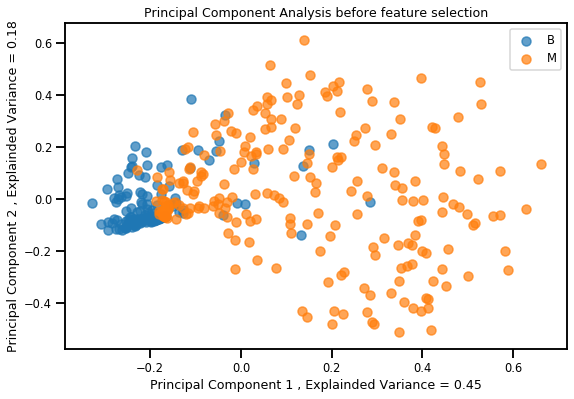

In [23]:
sns.set_context("talk", font_scale=0.7)
plt.figure(figsize=(9,6))
plt.scatter(xkpca.loc[(ytrain == 0).ravel(),0],xkpca.loc[(ytrain == 0).ravel(),1], alpha = 0.7, label = 'B')
plt.scatter(xkpca.loc[(ytrain == 1).ravel(),0],xkpca.loc[(ytrain == 1).ravel(),1], alpha = 0.7, label = 'M')
plt.xlabel('Principal Component 1 , Explainded Variance = ' + str(np.round(eigenvalues[0],2)))
plt.ylabel('Principal Component 2 , Explainded Variance = ' + str(np.round(eigenvalues[1],2)))
plt.title('Principal Component Analysis before feature selection')
plt.legend(loc='upper right')
plt.show()

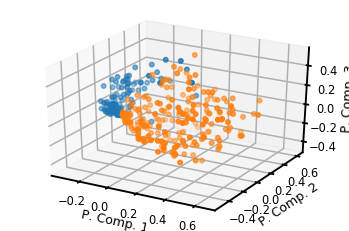

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xkpca.iloc[(ytrain == 0).ravel(),0], xkpca.iloc[(ytrain == 0).ravel(),1], xkpca.iloc[(ytrain == 0).ravel(),2])
ax.scatter(xkpca.iloc[(ytrain == 1).ravel(),0], xkpca.iloc[(ytrain == 1).ravel(),1], xkpca.iloc[(ytrain == 1).ravel(),2])
ax.set_xlabel('P. Comp. 1')
ax.set_ylabel('P. Comp. 2')
ax.set_zlabel('P. Comp. 3')
plt.show()

# Asignacion 01:
Partiendo de los datos originales crear un nuevo train-test split donde train es el 10% de los datos. Reducir la dimension con PCA y kPCA. Clasificar usando las proyecciones obtenidas con logistic regression. Medir la calidad de la clasificacion en area debajo de la curva y accuracy.

In [25]:
# train-test split con 0.9 test size, guardar el split, definir scaler .fit(xtrain), obtenemos xtrain_scal2 xtest_scal2
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x, y, test_size=0.9, random_state=4)
scaler2 = StandardScaler().fit(xtrain2)
xtrain2_scal = scaler.transform(xtrain2)  
xtest2_scal = scaler.transform(xtest2) 

In [26]:
xtrain2_scal.shape

(56, 30)

# PCA

In [27]:
n_comps = 10
pca2 = PCA(n_components= n_comps)
xpca2_train = pd.DataFrame(pca2.fit_transform(xtrain2_scal))
xpca2_test = pd.DataFrame(pca2.fit_transform(xtest2_scal))
eigenvalues2 = pca2.explained_variance_ratio_

In [28]:
eigenvalues2

array([0.4301938 , 0.19393803, 0.0960022 , 0.06579603, 0.05822793,
       0.04207732, 0.02255623, 0.01640444, 0.01432023, 0.01202186])

In [29]:
percentage_var_explained = eigenvalues2 / np.sum(eigenvalues2)
cum_var_explained = np.cumsum(eigenvalues2)

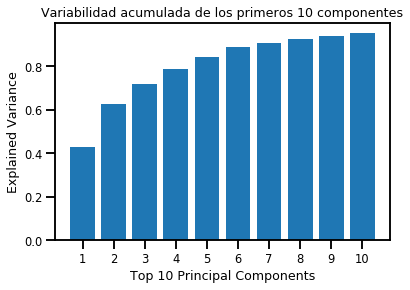

In [30]:
components = range(1,n_comps + 1)
plt.bar(components,cum_var_explained)
plt.xticks(components)
plt.title('Variabilidad acumulada de los primeros 10 componentes')
plt.xlabel('Top 10 Principal Components')
plt.ylabel('Explained Variance')
plt.show()

# KPCA


In [119]:
n_comps = 10
kpca2 = KernelPCA(n_components= n_comps, kernel = 'rbf', gamma = 1/n_comps)
xkpca2_train = pd.DataFrame(kpca2.fit_transform(xtrain2_scal))
xkpca2_test = pd.DataFrame(kpca2.fit_transform(xtest2_scal))

# LR

In [120]:
lr_pca = LogisticRegression(solver = 'lbfgs')
lr_kpca = LogisticRegression(solver = 'lbfgs')

In [121]:
lr_pca.fit(xpca2_train,ytrain2)
lr_kpca.fit(xkpca2_train,ytrain2)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [122]:
ypred_pca = lr_pca.predict(xpca2_test)
ypred_kpca = lr_kpca.predict(xkpca2_test)

In [123]:
acc_lr_pca =  accuracy_score(ypred_pca, ytest2)
print("Accuracy:", acc_lr_pca)

Accuracy: 0.9220272904483431


In [124]:
ypred_pca = lr_pca.predict(xpca2_test)
fpr, tpr, thresholds = roc_curve(ytest2.astype('int'), ypred_pca, drop_intermediate = False)
auc = metrics.auc(fpr, tpr)
print("El AUC es = " + str(auc))

El AUC es = 0.9272486772486773


In [125]:
acc_lr_kpca =  accuracy_score(ypred_kpca, ytest2)
print("Accuracy:", acc_lr_kpca)

Accuracy: 0.7914230019493177


In [126]:
ypred_kpca = lr_pca.predict(xkpca2_test)
fpr1, tpr1, thresholds1 = roc_curve(ytest2.astype('int'), ypred_kpca, drop_intermediate = False)
auc1 = metrics.auc(fpr1, tpr1)
print("El AUC es = " + str(auc1))


El AUC es = 0.19025573192239859
